In [8]:
import torch
import MDAnalysis as mda
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
import os
import os.path as osp
import warnings
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

#from full_VGAE_egnn_clean import *

from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import torch_geometric.transforms as T
from torch_geometric.nn.pool import global_mean_pool
import math

from torch.utils.tensorboard import SummaryWriter
import itertools
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm


In [9]:
import sys
sys.path.append("LIBS")
from LIBS.utils import *
from LIBS.FGVAE import *

   
# include_atom_type: bool = True,
# scale_features: bool = True,
# scale_pos: bool = True,
# initial_alignment: bool = False,

INCLUDE_ATOM_TYPE = True
SCALE_FEATURES = True   
SCALE_POS = False
INITIAL_ALIGNMENT = False

dataset = get_dataset( include_atom_type=INCLUDE_ATOM_TYPE,
                       scale_features=SCALE_FEATURES,
                       scale_pos=SCALE_POS,
                       initial_alignment=INITIAL_ALIGNMENT)

Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



In [10]:
dataset[0].pos

tensor([[13.0000, 17.9100, 25.2600],
        [12.0200, 18.0300, 24.8000],
        [12.8600, 17.2700, 26.1300],
        [13.3500, 18.8900, 25.5900],
        [14.0800, 17.3900, 24.3200],
        [14.6900, 16.3900, 24.7000],
        [14.1300, 17.8900, 23.0800],
        [13.5500, 18.7000, 22.9400],
        [15.2100, 17.6100, 22.1600],
        [16.0200, 17.1600, 22.7300],
        [14.6600, 16.6300, 21.1200],
        [14.3600, 15.6600, 21.5200],
        [13.8900, 16.9500, 20.4200],
        [15.4700, 16.4600, 20.4100],
        [15.7900, 18.8500, 21.4900],
        [15.0600, 19.7400, 21.0500],
        [17.0900, 18.8700, 21.2200],
        [17.6800, 18.1000, 21.5200],
        [17.8600, 19.8100, 20.4300],
        [17.2000, 20.3700, 19.7800],
        [18.5400, 20.8700, 21.2800],
        [19.3100, 20.3400, 21.8400],
        [18.9600, 21.6500, 20.6400],
        [17.7600, 21.4000, 21.8300],
        [18.8900, 19.1300, 19.5300],
        [19.3900, 18.0400, 19.7700],
        [19.3200, 19.8400, 18.4900],
 

Number of edges: 51
distances shape: torch.Size([51])
distances mean: 1.2310479879379272
distances std: 0.18703922629356384


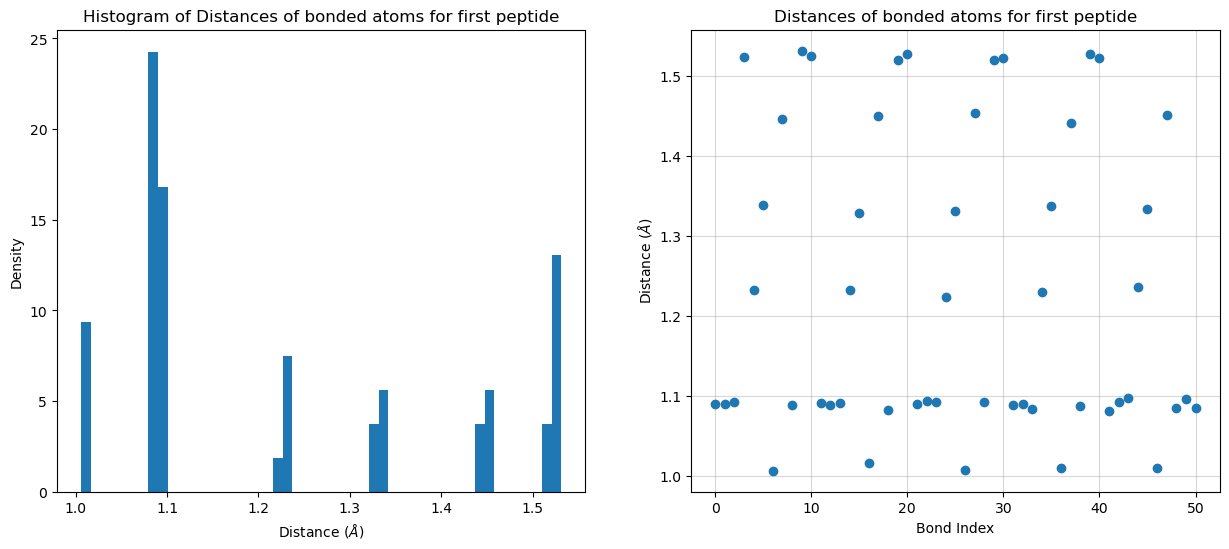

In [11]:
data = dataset[0]
pos = data.pos
edge_index = data.edge_index


fig, ax = plt.subplots(1,2, figsize=(15,6))
# plot an histogram of the distances between atoms

edge_index_single = edge_index[:, edge_index[0] < edge_index[1]]
distances = torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1)

print("Number of edges:", edge_index_single.shape[1])
print("distances shape:", distances.shape)
print("distances mean:", distances.mean().item())
print("distances std:", distances.std().item())

ax[0].hist(distances.numpy(), bins=50, density=True)
ax[0].set_xlabel(r'Distance ($\AA$)')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of Distances of bonded atoms for first peptide')


ax[1].plot(np.arange(len(distances)), distances.numpy(), 'o')
ax[1].set_xlabel('Bond Index')
ax[1].set_ylabel(r'Distance ($\AA$)')
ax[1].set_title('Distances of bonded atoms for first peptide')
ax[1].grid(alpha=0.5)
plt.show()



| Type of Interaction                 | Distance (Å)  | Distance (nm)  |
| ----------------------------------- | ------------- | -------------- |
| Covalent bond (C–H, C–C, N–H, etc.) | \~1.0 – 1.5 Å | 0.10 – 0.15 nm |
| Hydrogen bond                       | \~1.5 – 2.5 Å | 0.15 – 0.25 nm |
| Van der Waals interactions          | \~3.0 – 4.0 Å | 0.30 – 0.40 nm |
| Radius of a molecule                | 5 – 15 Å      | 0.5 – 1.5 nm   |


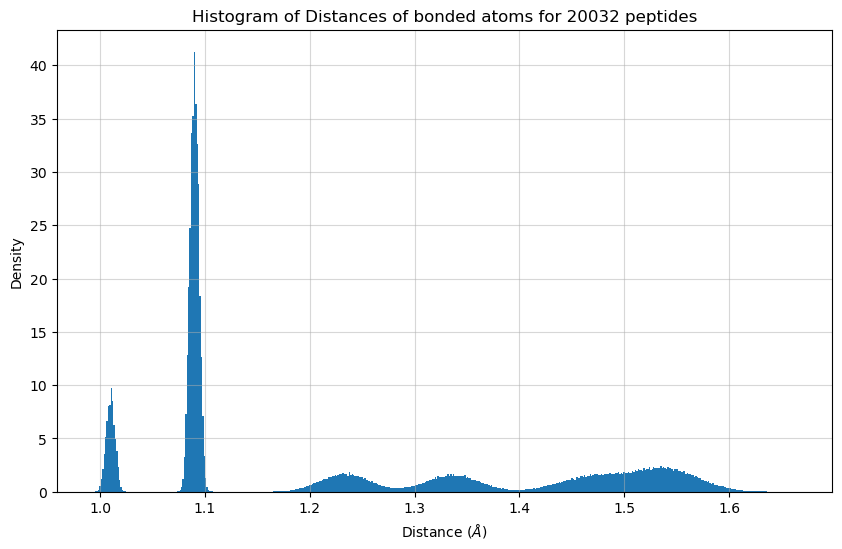

distances shape: torch.Size([1021632])
Distances mean: 1.2361741065979004
Distances std: 0.19184741377830505


In [12]:
# here I can use edge_index_single from before since it the same for all peptides
true_distances = []
n_peptides = len(dataset)
for data in dataset[:n_peptides]:
    pos = data.pos
    
    # plot an histogram of the distances between atoms
    true_distances.append(torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1))

true_distances = torch.cat(true_distances)
plt.figure(figsize=(10, 6))
plt.hist(true_distances, bins=500, density=True)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram of Distances of bonded atoms for {n_peptides} peptides')
plt.grid(alpha=0.5)
plt.show()

print ("distances shape:", true_distances.shape)
print("Distances mean:", true_distances.mean().item())
print("Distances std:", true_distances.std().item())

In [13]:
# Load the models 
EPOCHS = 60

ENCODER_TYPE = 'standard'
HIDDEN_ENCODER_CHANNELS = 256
OUT_ENCODER_CHANNELS = 128 
NUM_ENC_LAYERS = 9
ATTENTION_ENCODER = True
#LATENT_DIM = 128
TANH_ENCODER = False
NORMALIZE_ENCODER = False

# decoder
MLP_DECODER_POS_SIZE = [256,256,128]
HIDDEN_DECODER_CHANNELS = 256
NUM_DEC_LAYERS = 9
ATTENTION_DECODER = True
TANH_DECODER = False
NORMALIZE_DECODER =  False

lr = 0.0001
kl_min = 0.0001
latent_dim = 128

ARCHITECTURE = 'hybrid_displacement'
FOLDER_NAME = 'test'
ENCODER_POS_PROJECTION_DIM = 64



model = FGVAE(encoder=EGNN_Encoder(
    in_channels=dataset[0].num_features,
    architecture=ARCHITECTURE,
    hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
    pos_projection_dim=ENCODER_POS_PROJECTION_DIM,
    out_channels_egnn=OUT_ENCODER_CHANNELS,
    num_egnn_layers=NUM_ENC_LAYERS,
    attention=ATTENTION_ENCODER,
    tanh=TANH_ENCODER,
    normalize=NORMALIZE_ENCODER,
    latent_dim=latent_dim
),
decoder=EGNN_Decoder(
    latent_dim=latent_dim,
    node_feature_dim_initial=dataset[0].num_features,
    architecture=ARCHITECTURE,
    hidden_nf=HIDDEN_DECODER_CHANNELS,
    num_egnn_layers=NUM_DEC_LAYERS,
    attention=ATTENTION_DECODER,
    tanh=TANH_DECODER,
    normalize=NORMALIZE_DECODER,
    pos_MLP_size=MLP_DECODER_POS_SIZE
))

try:
    path_model = f'../JIMI_RUNS/{ARCHITECTURE}/{FOLDER_NAME}/sim_lr_{lr}_layers_{NUM_ENC_LAYERS}_kl_min_{kl_min}_latent_dim_{latent_dim}/model_epoch_{EPOCHS}.pth'
    print(f'Loading model from {path_model}')
    model.load_state_dict(torch.load(path_model))
except FileNotFoundError:
     print(f"Model file not found: {path_model}")


Loading model from ../JIMI_RUNS/hybrid_displacement/test/sim_lr_0.0001_layers_9_kl_min_0.0001_latent_dim_128/model_epoch_60.pth


In [14]:
dataset_scaled = get_dataset(scale_pos=True)

dataset_scaled[0].pos

Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt

Scaling positions... Max absolute position values for scaling: tensor([28.9800, 29.0000, 29.0100])
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



tensor([[0.4486, 0.6176, 0.8707],
        [0.4148, 0.6217, 0.8549],
        [0.4438, 0.5955, 0.9007],
        [0.4607, 0.6514, 0.8821],
        [0.4859, 0.5997, 0.8383],
        [0.5069, 0.5652, 0.8514],
        [0.4876, 0.6169, 0.7956],
        [0.4676, 0.6448, 0.7908],
        [0.5248, 0.6072, 0.7639],
        [0.5528, 0.5917, 0.7835],
        [0.5059, 0.5734, 0.7280],
        [0.4955, 0.5400, 0.7418],
        [0.4793, 0.5845, 0.7039],
        [0.5338, 0.5676, 0.7036],
        [0.5449, 0.6500, 0.7408],
        [0.5197, 0.6807, 0.7256],
        [0.5897, 0.6507, 0.7315],
        [0.6101, 0.6241, 0.7418],
        [0.6163, 0.6831, 0.7042],
        [0.5935, 0.7024, 0.6818],
        [0.6398, 0.7197, 0.7335],
        [0.6663, 0.7014, 0.7528],
        [0.6542, 0.7466, 0.7115],
        [0.6128, 0.7379, 0.7525],
        [0.6518, 0.6597, 0.6732],
        [0.6691, 0.6221, 0.6815],
        [0.6667, 0.6841, 0.6374],
        [0.6573, 0.7172, 0.6422],
        [0.7063, 0.6731, 0.6088],
        [0.728

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model.to(device)

# Calculate the mean reference structure for hybrid displacement
print("Calculating mean reference structure for the hybrid model...")
all_pos = torch.stack([data.pos for data in dataset_scaled], dim=0)  # Shape: (num_graphs, num_atoms, 3)
pos_ref_single = all_pos.mean(dim=0).to(device)  # Shape: (num_atoms, 3)


dataloader = DataLoader(dataset_scaled, batch_size=1, shuffle=False)
model.eval()

recon_positions = []
with torch.no_grad():
    for data in tqdm(dataloader, desc="Evaluating model"):
        data = data.to(device)
        pos_recon, _, _, _= model(data, pos_ref=pos_ref_single)
        recon_positions.append(pos_recon)


Using device: cuda
Calculating mean reference structure for the hybrid model...


Evaluating model: 100%|██████████| 20032/20032 [02:31<00:00, 132.64it/s]


In [ ]:
recon_positions[0]

tensor([[0.6338, 0.6427, 0.9075],
        [0.6314, 0.6398, 0.9140],
        [0.6291, 0.6396, 0.9143],
        [0.6301, 0.6417, 0.9146],
        [0.6436, 0.6539, 0.8864],
        [0.6493, 0.6549, 0.8799],
        [0.6472, 0.6546, 0.8716],
        [0.6386, 0.6546, 0.8762],
        [0.6583, 0.6598, 0.8490],
        [0.6641, 0.6524, 0.8542],
        [0.6505, 0.6541, 0.8581],
        [0.6479, 0.6544, 0.8594],
        [0.6475, 0.6541, 0.8593],
        [0.6483, 0.6541, 0.8596],
        [0.6713, 0.6816, 0.8056],
        [0.6688, 0.6984, 0.7943],
        [0.6946, 0.6777, 0.7851],
        [0.6990, 0.6599, 0.7972],
        [0.7076, 0.6899, 0.7485],
        [0.7081, 0.7110, 0.7512],
        [0.7463, 0.6832, 0.7559],
        [0.7543, 0.6782, 0.7569],
        [0.7544, 0.6782, 0.7566],
        [0.7544, 0.6783, 0.7568],
        [0.6982, 0.6793, 0.7084],
        [0.6886, 0.6693, 0.7003],
        [0.6984, 0.6823, 0.6843],
        [0.7086, 0.6916, 0.6952],
        [0.6844, 0.6759, 0.6402],
        [0.673

In [ ]:
losses = []
for i, data in enumerate(dataset_scaled):
    pos = data.pos.to(device)
    pos_recon = recon_positions[i]
    
    # Calculate the loss
    loss = F.mse_loss(pos,pos_recon).item()
    losses.append(loss)

Best reconstruction loss: 0.0015103532932698727 for peptide index 17027


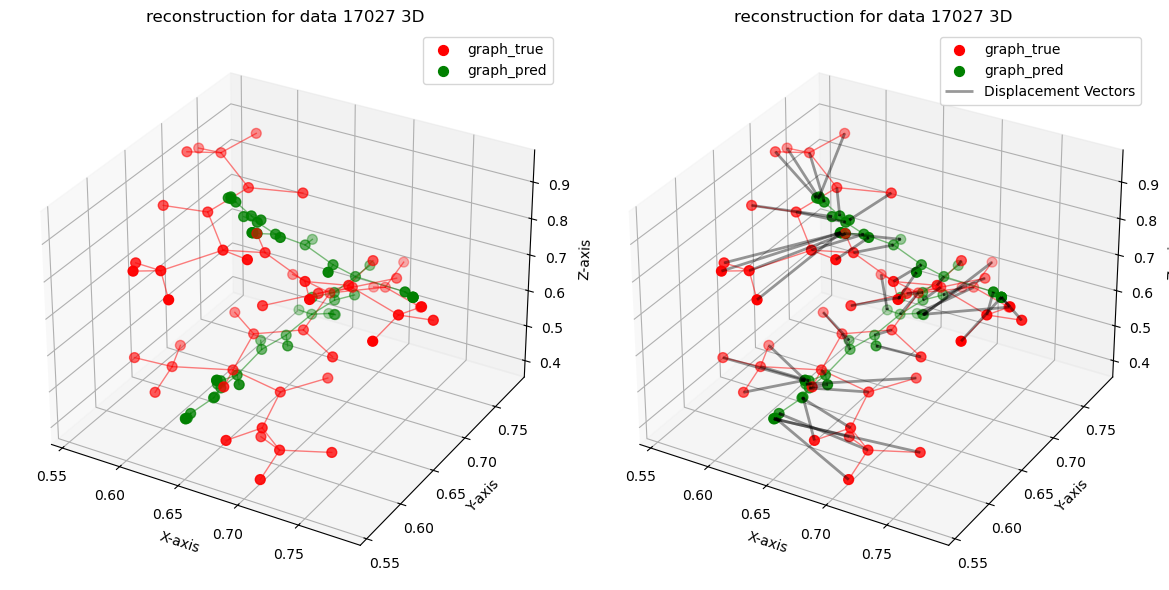

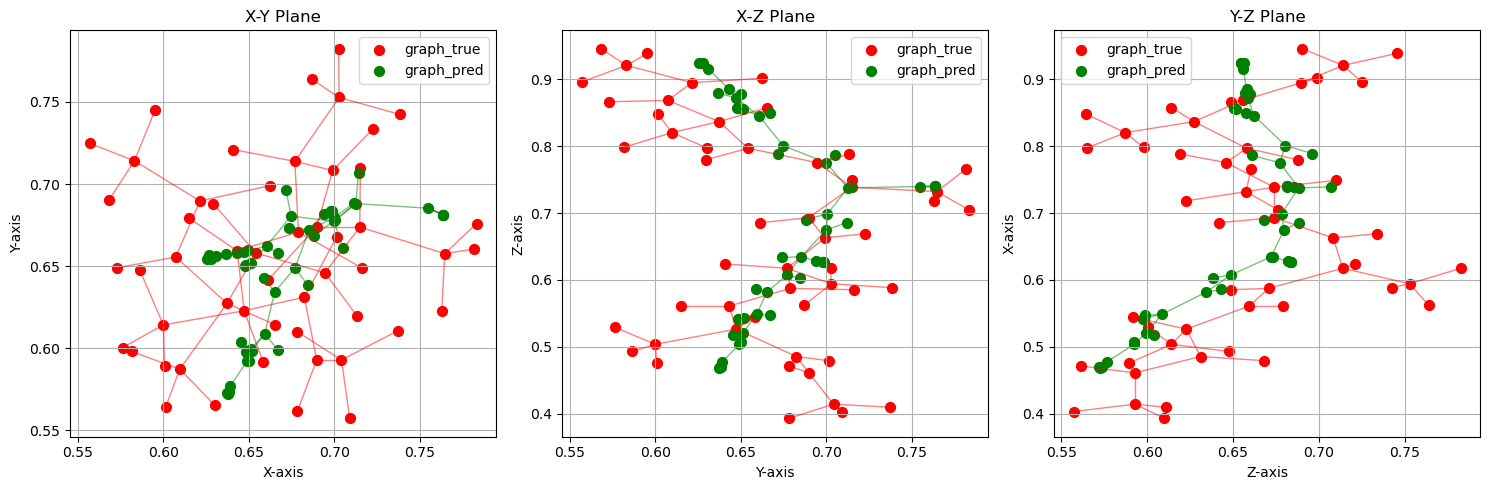

In [ ]:
best_index = np.argmin(losses).item()
print(f"Best reconstruction loss: {losses[best_index]} for peptide index {best_index}")

pos_recon_best = recon_positions[best_index].cpu()
data_true_best = dataset_scaled[best_index]

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

plot_graph_pred(pos_recon_best, data_true_best, ax=ax[0], title=f"reconstruction for data {best_index} 3D", planewise=False,quiver=False)
plot_graph_pred(pos_recon_best, data_true_best, ax=ax[1], title=f"reconstruction for data {best_index} 3D", planewise=False)
plot_graph_pred(pos_recon_best, data_true_best, title=f"reconstruction for data {best_index} 2D", planewise=True,quiver=False)



Reconstructed positions shape: (20032, 52, 3)


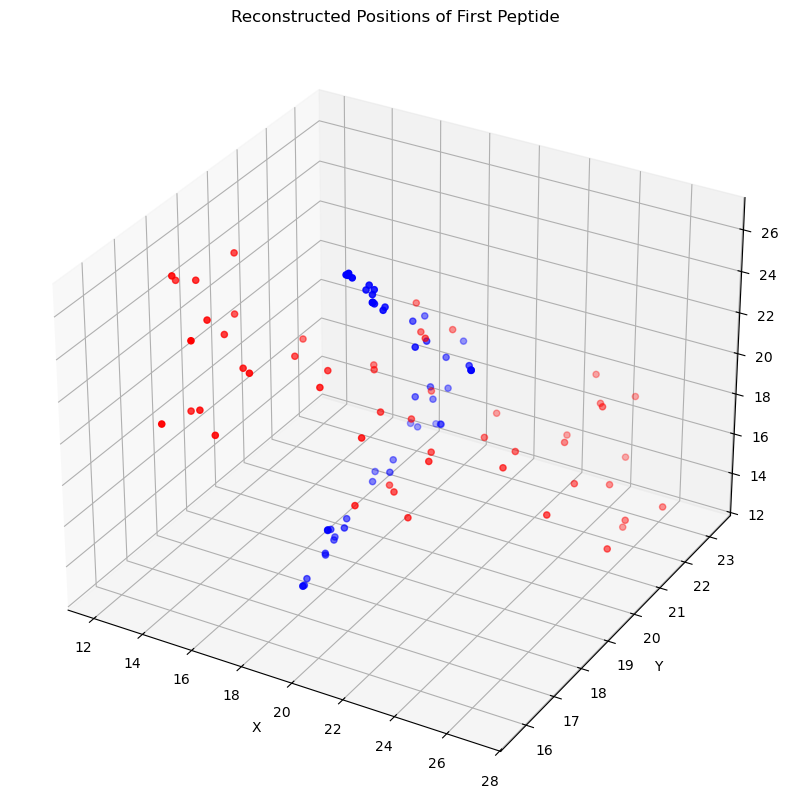

In [ ]:
# rescale back to original scale
max_pos = torch.tensor([28.9800, 29.0000, 29.0100])

pos_recon_rescaled_tensor = torch.stack(recon_positions, dim=0)* max_pos.to(device)
# Move to CPU and convert to numpy
pos_recon_rescaled_tensor = pos_recon_rescaled_tensor.cpu()
pos_recon_rescaled = pos_recon_rescaled_tensor.cpu().numpy()

pos_true = torch.stack([data.pos for data in dataset], dim=0) 

print("Reconstructed positions shape:", pos_recon_rescaled.shape)
# Plot the first reconstructed peptide
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')  
ax.scatter(pos_recon_rescaled[0, :, 0], pos_recon_rescaled[0, :, 1], pos_recon_rescaled[0, :, 2], c='b', marker='o')
ax.scatter(pos_true[0, :, 0], pos_true[0, :, 1], pos_true[0, :, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Reconstructed Positions of First Peptide')
plt.show()

Number of peptides: 20032
distances shape: torch.Size([])


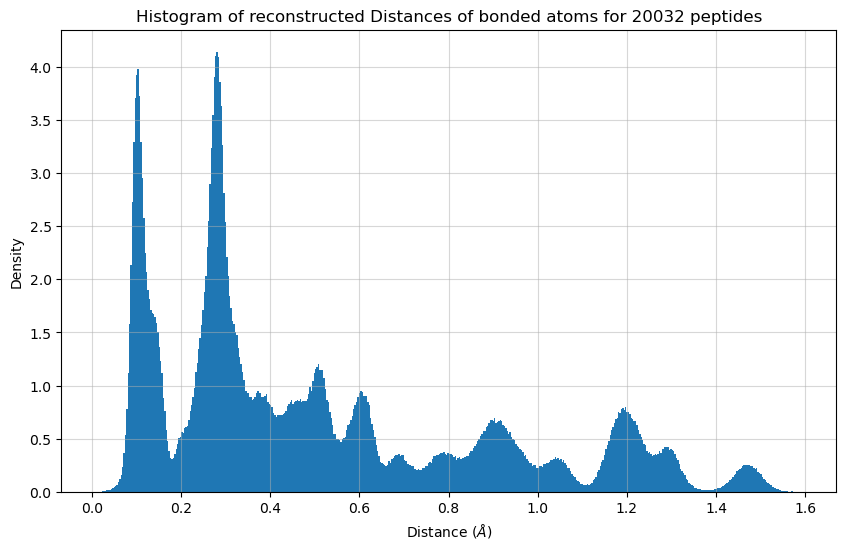

distances shape: torch.Size([1021632])
Distances mean: 0.5065963268280029
Distances std: 0.3733885884284973


In [ ]:
# here I can use edge_index_single from before since it the same for all peptides
distances = []
n_peptides = pos_recon_rescaled_tensor.shape[0]
print("Number of peptides:", n_peptides)

# plot an histogram of the distances between atoms
for pos in pos_recon_rescaled_tensor:

    # plot an histogram of the distances between atoms
    distances.append(torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1))

distances = torch.cat(distances)

print("distances shape:", distances[0].shape)
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=500, density=True)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram of reconstructed Distances of bonded atoms for {n_peptides} peptides')
plt.grid(alpha=0.5)
plt.show()

print ("distances shape:", distances.shape)
print("Distances mean:", distances.mean().item())
print("Distances std:", distances.std().item())

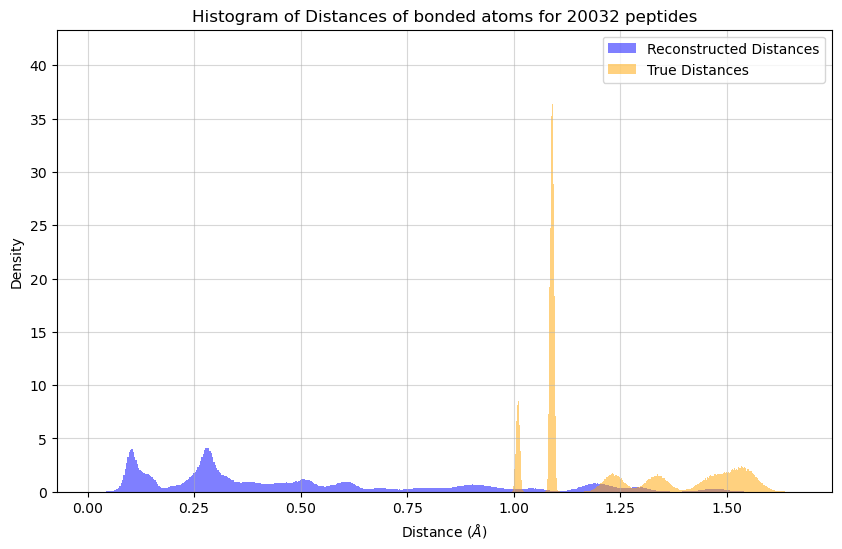

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=500, density=True, alpha=0.5, label='Reconstructed Distances', color='blue')
plt.hist(true_distances, bins=500, density=True, alpha=0.5, label='True Distances', color='orange')
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram of Distances of bonded atoms for {n_peptides} peptides')
plt.legend()
plt.grid(alpha=0.5)
plt.show()
